In [1]:
'''Core updated as of 7th Februrary with Leonardo's fixes'''
import numpy as np
from numpy import random as npr
import pandas as pd
from matplotlib import pyplot as plt
import copy
import itertools
# import itertools as it'

In [2]:
# INITIAL DATA:_____________________________________________
cooperate = np.array( [ 1, 0 ] )
defect = np.array( [ 0, 1 ] )

# default Payoff matrix
default_R = 2
default_S = 0
default_T = 3
default_P = 1
Payoff = np.array( [ [ default_R , default_S ], [ default_T, default_P ] ] )

In [3]:
# NEW STRATEGIES:________________________________________________

# defining all strategies
# # template function
# parameter_list = [ k, ]
# def strategy( round_number = 0, match_history = [[]], player_index = 0 ) : 
#     # move either cooperate or defect
#     move
#     return move 

# nice guy function
def nice_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    return move 

# bad guy function
def bad_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = defect
    return move 

# percentage of defect for mainly nice ( and 1-k percentage of cooperate for mainly bad) Global Variable
k = 0.25

# mainly nice guy: randomly defect k% of the times and cooperate 100-k %, k<50
def mainly_nice( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < k ) : move = defect
    else :         move = cooperate
    return         move

# mainly bad guy: randomly defect k% of the times and cooperate 100-k %, k>50
def mainly_bad( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u > k ) : move = defect
    else :         move = cooperate
    return         move

# random guy: randomly defect or cooperate
def random_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < 0.5 ) : move = defect
    else :           move = cooperate
    return           move

# tit_for_tat function:  start by cooperating, then repeat what the opponent has done in the previous move
def tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = cooperate
    else :                     move = match_history[ round_number - 1 ][ 1 - player_index ]
    return                     move

# resentful guy function: cooperate until the opponent defects once, then always defect
def resentful_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    if ( round_number > 0 ) :
        for res in match_history : 
            # if any result matching a defect is found, the move is set to defect
            if np.array_equal( res[ 1 - player_index  ], defect ) : move = defect
            # if a defect is found, he would break    
            break
    return move

# trusting guy (increasing odds of cooperating according to match history):
# initially is like random guy (coop/defect at k=50%), then updates k
def trusting_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # starting trust
    k_t = 0.5
    # environmental trust
    if ( round_number > 0 ) :
        # number of cooperative behaviour met
        coop = 0. 
        # increase the value of cooperation by one each cooperation (element 0) seen from the other player (index 1-player_index)
        for res in match_history : coop += res[ 1 - player_index  ][ 0 ]
        # normalizing result over the match history
        k_t = coop / len( match_history )
    u = npr.random( )
    if ( u > k ) : move = defect
    else :         move = cooperate
    return         move

# balancing guy (cooperates only for an even cooperation history)
def balancing_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    move = defect
    if ( round_number > 0 ) :
        # total cooperation seen
        coop = 0
        # increase the value of cooperation by one each cooperation (element 0) seen from each side during the match
        for res in match_history : coop += ( res[ 0 ][ 1 ] + res[ 1 ][ 1 ])
        if ( ( coop % 2 ) == 0 ) : move = cooperate
    return                         move

# Mid resentful: cooperates on the first move, and defects if the opponent has defected on any of the previous 3 moves, else cooperates
def mid_resentful( round_number = 0, match_history = [[]], player_index = 0):
    move = cooperate
    # selecting the oldest round to check, 3 before the current one if possible, the starting round otherwise
    start = max(0, round_number - 3)
    for round_i in range( start, round_number ):
        # checking if one of the previous move of the opponent (1-player_index) mach a defect
        if np.array_equal( match_history[round_i][1 - player_index], defect ):   
            move = defect
            # if a result is found, the cycle can break
            break
    return move

# reverse tit_for_tat function: start by defecting, then does the opposite of what the opponent has done in the previous move
def reverse_tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = defect
                               # in this way i obtain the opposite move: [1,1] - [1,0] = [0,1] and [1,1] - [0,1] = [1,0]
    else :                     move = [1,1] - match_history[ round_number - 1 ][ 1 - player_index ]  
    return                     move

# learning to scam guy: start by defecting, then cooperating two times; for the following turns chose the optimal condition:
# if the opponent never defected, he will defect to scam the opponent
# if the opponent cooperated while he cooperated more than he was scammed, he will cooperate, because he sees some kind of intelligence
# otherwise he'll defect to avoid beeing scammed
def scamming_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # default move is defect
    move =  defect
    # selecting first tree moves
    if ( round_number == 0 )   : 
        # print( f"round {round_number}: I defect" )
        move = defect
    elif ( round_number == 1 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    elif ( round_number == 2 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    else :
        # counting number of matching cooperation isses and defected from 0
        matching_coop = 0
        scammed = 0
        # deciding how much history to check
        first_r = npr.randint( 3, ( round_number + 1 ), dtype = int )
        # print( first_r )
        # searching over match history
        for i in range( round_number ) :
            # checking if the result cooperate, cooperate occurs
            if( np.array_equal( match_history[i][0], cooperate ) and np.array_equal( match_history[i][1], cooperate ) ) :
                matching_coop += 1
            # checking if the result cooperate, defect occurs in favour of the opposite side
            elif( np.array_equal( match_history[i][1 - player_index], defect ) and np.array_equal( match_history[i][player_index], cooperate ) ) :
                scammed += 1
        # checking if the opponent ever defected
        if( np.all( np.array_equiv( np.array( [ match_history[i][ 1 - player_index ] for i in range( ( round_number - first_r ), round_number ) ] ) , cooperate ) ) ) :
            # print( f"The rival is too good, I defect" )
            move = defect
        elif( matching_coop >= scammed ) : 
            # print( f"The rival is smart, I cooperate" )
            move = cooperate
    return move

# dictionary of all strategies
strategies = {
    'NiceGuy' : nice_guy,
    'BadGuy' : bad_guy,
    'MainlyNice' : mainly_nice,
    'MainlyBad' : mainly_bad,
    'TitForTat' : tit_for_tat,
    'RandomGuy' : random_guy,
    'ResentfulGuy' : resentful_guy,
    'TrustingGuy' : trusting_guy,
    'Thanos' : balancing_guy,
    'MidResentful': mid_resentful,
    'ReverseTft': reverse_tit_for_tat,
    'ScammingGuy' : scamming_guy,
}


In [4]:
# NEW MATCH DEFINING FUNCTIONS:________________________________________________

# function to play one round 1 vs 1 for two different* strategies players
def round( key_1, key_2, round_number, match_history, M = Payoff ) :
    # getting strategies from dictionary
    S_1 = strategies[ key_1 ]
    S_2 = strategies[ key_2 ]
    # computing next move for each player
    u_1 = S_1( round_number, match_history, 0 )
    u_2 = S_2( round_number, match_history, 1 )
    # computing rewards for each player
    r_1 = np.dot( u_1, M.dot(u_2))
    r_2 = np.dot( u_2, M.dot(u_1))
    # updating match history
    match_history.append( [ u_1, u_2 ] )
    # returning results
    return r_1, r_2

# function to play a match of N rounds 1 vs 1 for two different* strategies player
def match( key_1, key_2, N_rounds = 10, M = Payoff ) : 
    # match history strarting empty
    history = [ ]
    # starting total rewards
    R_1 = 0
    R_2 = 0
    # list of partial sums
    Rewards = []
    for round_i in range( 0, N_rounds ) :
        r_1, r_2 = round( key_1, key_2, round_i, history, M )
        R_1 += r_1
        R_2 += r_2
        Rewards.append( [ R_1, R_2 ] )
    # returns the history list of partial sums of rounds rewards
    return Rewards

In [5]:
def tourney(participants={},N_rounds = 10, M = Payoff):
    # Retrieve only the names of the strategies repeated as many times as their frequency allows.
    player_list_from_dict = []
    for item in (list(participants.keys())):
        for i in range (participants[item]):
            player_list_from_dict.append(item)
    # Compute the combinations
    b = list(itertools.combinations(player_list_from_dict, 2))
    N_giornata = len(b)
    # List which will be used to have the scores of each match by the side of the two opponents
    list_with_scores = b
    # Loop over the combinations one by one
    for i in range (N_giornata):
        # Player1 and Player2 strategies
        player1 = b[i][0]
        player2 = b[i][1]
        # Initiliaze an empty list to store the results over the match
        AllRewards = []
        # Do the match between the two players and update the rewards; The ordered syntax for match is:
        # match( key_1, key_2, N_rounds = 10, M = Payoff ) : 
        AllRewards =  match(player1, player2, N_rounds, M)
        # Retrieve the final scores for Player1 and Player2 as the last element in the list
        R1, R2 = AllRewards[-1][0], AllRewards[-1][1]
        list_with_scores[i] += (R1,R2)
    # Un-comment the following print to debug
    #for item in list_with_scores: print(item)
    
    # Good, now each combination has the corresponding score: we now need to assign it to the respective players and calculate the final score
    strat = list(participants.keys())
    freq = [participants[key] for key in strat]
    named =[]
    # Add identification to the layer trough the use of a numerical value from 1 up to their frequency BUT PRESERVE THE ORDER
    for key,f in zip (strat,freq):
        for j in range(1,f+1):
            if (f!=0):
                named.append(key + str(j))
    # Compute the permutations preserving the order
    with_names = list(itertools.combinations(named,2))
    # Copy the scores for each match over to the ones with identification
    # In list_with_scores[I][J] we have: I = ordered number of the combination, and J:
    # J=0 is 1st strategy; J=1 is 2nd strategy; J=2 is Player1 score; J=3 is Player2 score
    for i in range (N_giornata): with_names[i] += (list_with_scores[i][2],list_with_scores[i][3] )
    # Un-comment the following print to debug
    #for item in with_names: print(item)

    # Compute the score for each named player and add it to the list
    FinalScores = []
    for player in named:
        SumOver1 = np.sum([ with_names[i][2] for i in range (N_giornata) if (with_names[i][0] == player) ])
        SumOver2 = np.sum([ with_names[i][3] for i in range (N_giornata) if (with_names[i][1] == player) ])
        FinalScores.append(SumOver1 + SumOver2)
    Results = named
    
    for i in range (len(Results)):
        Results[i] = (Results[i],FinalScores[i])

    return ( Results )    

In [6]:
# Tourney test
test_part ={ 
    'NiceGuy' : 1,
    'BadGuy' : 1,
    'MainlyNice' : 1,
    'MainlyBad' : 1,
    'RandomGuy' : 1,
    'TitForTat' : 1,
    'ResentfulGuy' : 1,
    'TrustingGuy' : 1,
    'Thanos' : 1,
    'MidResentful' : 1,
    'ReverseTft': 1,
    'ScammingGuy': 1,
}

result = tourney(test_part,N_rounds = 10, M = Payoff)
#for item in result: print(item)
print("\nHere's the Ranking at the end of the tourney:")
# Sorted gives a copy, while using LIST.sort() does it in place.
Ranking = sorted(result,reverse=True, key=lambda x: x[1])
for item in Ranking: print(item)


Here's the Ranking at the end of the tourney:
('MainlyBad1', 194)
('BadGuy1', 186)
('MidResentful1', 179)
('TrustingGuy1', 172)
('ScammingGuy1', 172.0)
('RandomGuy1', 165)
('TitForTat1', 163)
('Thanos1', 160)
('ResentfulGuy1', 158)
('MainlyNice1', 150)
('ReverseTft1', 137)
('NiceGuy1', 122.0)


In [7]:
# Retrieve the participants to the tourney as the players with non-zero frequency: needed to avoid divisions by zero with the mean
labels = [ x for (x,f) in test_part.items() if f!=0 ]
# Get the name of the player, that is the strategy with numerical identifier
players = [ result[i][0] for i in range (len(result)) ]
# Get their respective scores
rewards = [ result[i][1] for i in range (len(result)) ]

mean_rewards= []
index = 0
for item in players:
    # Make it a string to apply the count method: returns the number of times a substring is included in the main string
    f = str(players).count(item)
    # Compute the mean of their rewards: since players in result are listed in strategy order this is valid
    mean = (np.sum(rewards[index:index+f]))/f
    mean_rewards.append(mean)
    index += f
mean_ranking = list(zip(labels, mean_rewards))
mean_ranking.sort(reverse=True, key=lambda x: x[1])
for item in mean_ranking: print(item[0], f"{item[1]:.2f}")

MainlyBad 194.00
BadGuy 186.00
MidResentful 179.00
TrustingGuy 172.00
ScammingGuy 172.00
RandomGuy 165.00
TitForTat 163.00
Thanos 160.00
ResentfulGuy 158.00
MainlyNice 150.00
ReverseTft 137.00
NiceGuy 122.00


In [8]:
# Syntax [T,R,P,S]
def get_new_Payoff(par_list=[3,2,1,0]):
    if (len(par_list)!= 4):
        raise TypeError("Invalid parameter list for Payoff matrix")
    new_R = par_list[1]
    new_S = par_list[3]
    new_T = par_list[0]
    new_P = par_list[2]
    # Sanity checks
    if (np.min(par_list)!=new_S): raise ValueError("Parameters do not satisfy boundary conditions: S is not the smallest value")
    if (np.max(par_list)!=new_T): raise ValueError("Parameters do not satisfy boundary conditions: T is not the biggest value")
    if (new_P >= new_R): raise ValueError("Parameters do not satisfy boundary conditions: R is not greater than P")
    if (2*new_R <= new_T + new_S ): raise ValueError("Parameters do not satisfy boundary conditions: 2R is not greater than T+S")
    return np.array([ [ new_R , new_S ], [ new_T, new_P ] ])

In [9]:
# Syntax [T,R,P,S]
l2 = [5,3,2,0]
pay_mat = get_new_Payoff(l2)
print(pay_mat)

# Let's suppose we decide the maximum value to assign to the reward for succesfully defecting (T) and succesfully cooperating (R) (T>R)
# Then due to the boundary conditions restrictions we get for the other two parameters the following:
# Reward for both defecting P: 2R-T < P < R
# Reward for being betrayed S: 0 <= S < 2R-T
max_T = 10
max_R = 8
possible_P = np.arange(2*max_R-max_T,max_R,1)
possible_S = np.arange(0,2*max_R-max_T,1)
print(possible_P)
print(possible_S)

[[3 0]
 [5 2]]
[6 7]
[0 1 2 3 4 5]


In [10]:
def test_parameters(max_T,max_R=max_T-1):
    set_of_parameters = []
    for t in range (3,max_T+1):
        max_coop = np.minimum(t,max_R)
        for r in range (2,max_coop+1):
            value = np.maximum(0,2*r-t)
            possible_P = np.arange(value,r,1)
            possible_S = np.arange(0,value,1)
            # Un-comment the following for debug
            #if (len(possible_S)!=0 and len(possible_P)!=0):
                #print(f"For T={t}, R={r}, we get the possible:")
                #print("P: ", possible_P)
                #print("S: ", possible_S)
            for i in range (len(possible_P)):
                for j in range(len(possible_S)):
                    set_of_parameters.append((t,r,possible_P[i],possible_S[j]))
    return (set_of_parameters)

In [11]:
# Sanity check
p_t = test_parameters(10)
for item in p_t:
    assign_test = get_new_Payoff(item)
    #print(f"{item} is ok")

In [12]:
Promote_Evil = [p_t[i] for i in range(len(p_t)) if (p_t[i][0]==p_t[-1][0])]
print(Promote_Evil)

[(10, 6, 2, 0), (10, 6, 2, 1), (10, 6, 3, 0), (10, 6, 3, 1), (10, 6, 4, 0), (10, 6, 4, 1), (10, 6, 5, 0), (10, 6, 5, 1), (10, 7, 4, 0), (10, 7, 4, 1), (10, 7, 4, 2), (10, 7, 4, 3), (10, 7, 5, 0), (10, 7, 5, 1), (10, 7, 5, 2), (10, 7, 5, 3), (10, 7, 6, 0), (10, 7, 6, 1), (10, 7, 6, 2), (10, 7, 6, 3), (10, 8, 6, 0), (10, 8, 6, 1), (10, 8, 6, 2), (10, 8, 6, 3), (10, 8, 6, 4), (10, 8, 6, 5), (10, 8, 7, 0), (10, 8, 7, 1), (10, 8, 7, 2), (10, 8, 7, 3), (10, 8, 7, 4), (10, 8, 7, 5), (10, 9, 8, 0), (10, 9, 8, 1), (10, 9, 8, 2), (10, 9, 8, 3), (10, 9, 8, 4), (10, 9, 8, 5), (10, 9, 8, 6), (10, 9, 8, 7)]


In [13]:
# Get the coefficients with the biggest disparity between T (succesfully defecting) and R (succesfully cooperating)
Most_Evil = get_new_Payoff(Promote_Evil[0])
# Get the coefficients with the lest disparity between T (succesfully defecting) and R (succesfully cooperating) but still high coeff values
Least_Evil = get_new_Payoff(Promote_Evil[-1])

result_Most_Evil = tourney(test_part,N_rounds = 10, M = Most_Evil)
#for item in result: print(item)
print("With Payoff Matrix: " + "\n", Most_Evil)
print("Here's the Ranking at the end of the tourney:")
# Sorted gives a copy, while using LIST.sort() does it in place.
Ranking_Most_Evil = sorted(result_Most_Evil,reverse=True, key=lambda x: x[1])
for item in Ranking_Most_Evil: print(item)

result_Least_Evil = tourney(test_part,N_rounds = 10, M = Least_Evil)
#for item in result: print(item)
print("\nWith Payoff Matrix: " + "\n" , Least_Evil)
print("Here's the Ranking at the end of the tourney:")
# Sorted gives a copy, while using LIST.sort() does it in place.
Ranking_Least_Evil = sorted(result_Least_Evil,reverse=True, key=lambda x: x[1])
for item in Ranking_Least_Evil: print(item)

With Payoff Matrix: 
 [[ 6  0]
 [10  2]]
Here's the Ranking at the end of the tourney:
('TrustingGuy1', 570)
('BadGuy1', 556)
('ScammingGuy1', 520.0)
('RandomGuy1', 516)
('MainlyBad1', 506)
('MidResentful1', 492)
('TitForTat1', 460)
('ResentfulGuy1', 460)
('Thanos1', 442)
('ReverseTft1', 418)
('MainlyNice1', 386)
('NiceGuy1', 300.0)

With Payoff Matrix: 
 [[ 9  7]
 [10  8]]
Here's the Ranking at the end of the tourney:
('BadGuy1', 972)
('MidResentful1', 949)
('MainlyBad1', 943)
('ScammingGuy1', 942.0)
('Thanos1', 939)
('ResentfulGuy1', 938)
('TitForTat1', 935)
('TrustingGuy1', 927)
('RandomGuy1', 923)
('ReverseTft1', 910)
('MainlyNice1', 901)
('NiceGuy1', 892.0)


In [14]:
# Are these significative? Let's check by normalizing for both the total number of match played and the highest value of Payoff matrix
# Currently N_rounds needs to be inserted manually
# Use Ranking_ for the sorted one, and result_ for the default order one
# Normalized_Most_Evil = [ ( Ranking_Most_Evil[i][0], Ranking_Most_Evil[i][1]/(10*(len(test_part)-1)*np.max(Most_Evil)) ) for i in range (len(Ranking_Most_Evil)) ]
Normalized_Most_Evil = [ ( result_Most_Evil[i][0], result_Most_Evil[i][1]/(10*(len(test_part)-1)*np.max(Most_Evil)) ) for i in range (len(result_Most_Evil)) ]
print("Normalized scores with Payoff Matrix: " + "\n", Most_Evil)
for item in Normalized_Most_Evil: print(item[0], f"{item[1]:.3f}")

Normalized scores with Payoff Matrix: 
 [[ 6  0]
 [10  2]]
NiceGuy1 0.273
BadGuy1 0.505
MainlyNice1 0.351
MainlyBad1 0.460
RandomGuy1 0.469
TitForTat1 0.418
ResentfulGuy1 0.418
TrustingGuy1 0.518
Thanos1 0.402
MidResentful1 0.447
ReverseTft1 0.380
ScammingGuy1 0.473


In [15]:
#Normalized_Least_Evil = [ ( Ranking_Least_Evil[i][0], Ranking_Least_Evil[i][1]/(10*(len(test_part)-1)*np.max(Least_Evil)) ) for i in range (len(Ranking_Least_Evil)) ]
Normalized_Least_Evil = [ ( result_Least_Evil[i][0], result_Least_Evil[i][1]/(10*(len(test_part)-1)*np.max(Least_Evil)) ) for i in range (len(result_Least_Evil)) ]
print("Normalized scores with Payoff Matrix: " + "\n", Least_Evil)
print("Normalized scores with Payoff Matrix: " + "\n", Least_Evil)
for item in Normalized_Least_Evil: print(item[0], f"{item[1]:.3f}")

Normalized scores with Payoff Matrix: 
 [[ 9  7]
 [10  8]]
Normalized scores with Payoff Matrix: 
 [[ 9  7]
 [10  8]]
NiceGuy1 0.811
BadGuy1 0.884
MainlyNice1 0.819
MainlyBad1 0.857
RandomGuy1 0.839
TitForTat1 0.850
ResentfulGuy1 0.853
TrustingGuy1 0.843
Thanos1 0.854
MidResentful1 0.863
ReverseTft1 0.827
ScammingGuy1 0.856


In [16]:
# What about our original results?
print("Normalized scores with Payoff Matrix: " + "\n", Payoff)
#Normalized_Ranking = [ ( Ranking[i][0], Ranking[i][1]/(10*(len(test_part)-1)*np.max(Payoff)) ) for i in range (len(Ranking)) ]
Normalized_Ranking = [ ( result[i][0], result[i][1]/(10*(len(test_part)-1)*np.max(Payoff)) ) for i in range (len(result)) ]
for item in Normalized_Ranking: print(item[0], f"{item[1]:.3f}")

Normalized scores with Payoff Matrix: 
 [[2 0]
 [3 1]]
NiceGuy1 0.370
BadGuy1 0.564
MainlyNice1 0.455
MainlyBad1 0.588
RandomGuy1 0.500
TitForTat1 0.494
ResentfulGuy1 0.479
TrustingGuy1 0.521
Thanos1 0.485
MidResentful1 0.542
ReverseTft1 0.415
ScammingGuy1 0.521


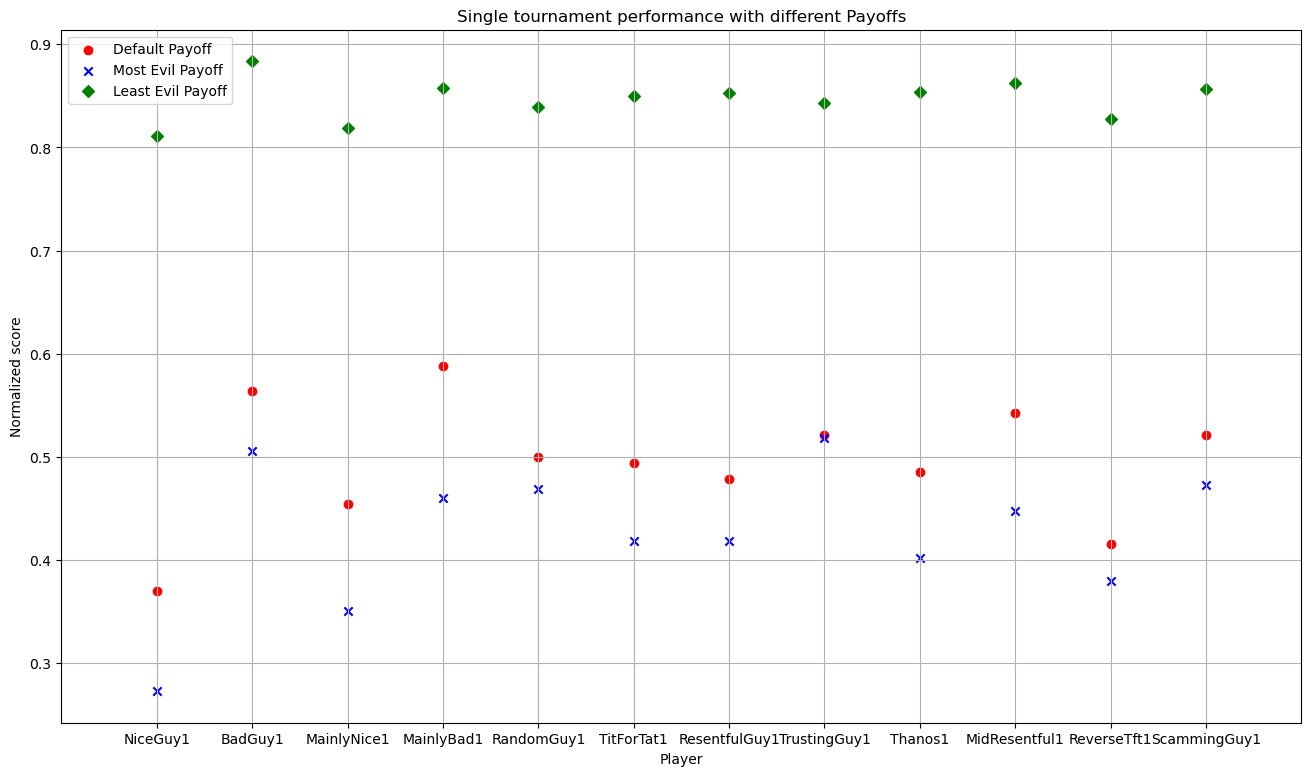

In [19]:
# Scatter plot to visualize results
names = [result[i][0] for i in range (len(result))]
x_vals = np.arange(1,len(names)+1,1)
y_res = [Normalized_Ranking[i][1] for i in range (len(Normalized_Ranking))]
y_most_evil = [Normalized_Most_Evil[i][1] for i in range (len(Normalized_Most_Evil))]
y_least_evil = [Normalized_Least_Evil[i][1] for i in range (len(Normalized_Least_Evil))]

fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(x_vals, y_res, label = "Default Payoff", color = "red", marker  = "o")
ax.scatter(x_vals, y_most_evil, label = "Most Evil Payoff", color = "blue", marker = "x")
ax.scatter(x_vals, y_least_evil, label = "Least Evil Payoff", color = "green", marker = "D")
ax.set_title("Single tournament performance with different Payoffs")
ax.set_xlabel("Player")
ax.set_xlim(0,len(names)+1)
ax.set_xticks(x_vals)
ax.set_ylabel("Normalized score")

ax.set_xticklabels(names)
ax.grid()

ax.legend()
plt.show()
